In [3]:
# coding:utf-8
# 注意读取文件时，Windows系统的\\和Linux系统的/的区别

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# 为了在jupyter notebook里作图，需要用到这个命令
%matplotlib inline



In [4]:
# 将csv数据转换为DataFrame数据，方便用pandas进行数据预处理
train_df = pd.read_csv(".\\data\\train.csv",index_col = 0)
test_df = pd.read_csv('.\\data\\test.csv',index_col = 0)
print (train_df.shape)
print (test_df.shape)
train_df.head()  # 默认展示前五行 这里是5行,80列
test_df.head()   # 这里是5行,79列

(1460, 80)
(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


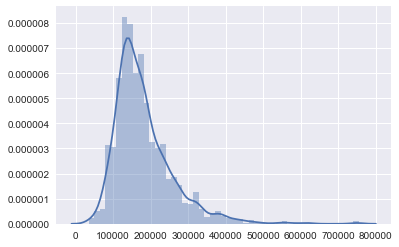

In [5]:
# 利用sea born绘制训练集提供的房价直方图
prices = pd.DataFrame({'price':train_df['SalePrice']})
sns.distplot(prices)

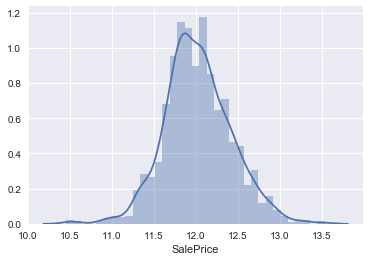

In [6]:
# 由上图可知分布偏左，对其取对数，使得其分布符合正态分布
prices_log = np.log(train_df['SalePrice'])
#print (prices_log)
sns.distplot(prices_log)

In [7]:
# step2 合并数据，进行数据预处理
y_train = np.log1p(train_df.pop('SalePrice'))
all_df = pd.concat((train_df,test_df),axis = 0)
print (all_df.shape)
print (y_train.head())

(2919, 79)
Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64


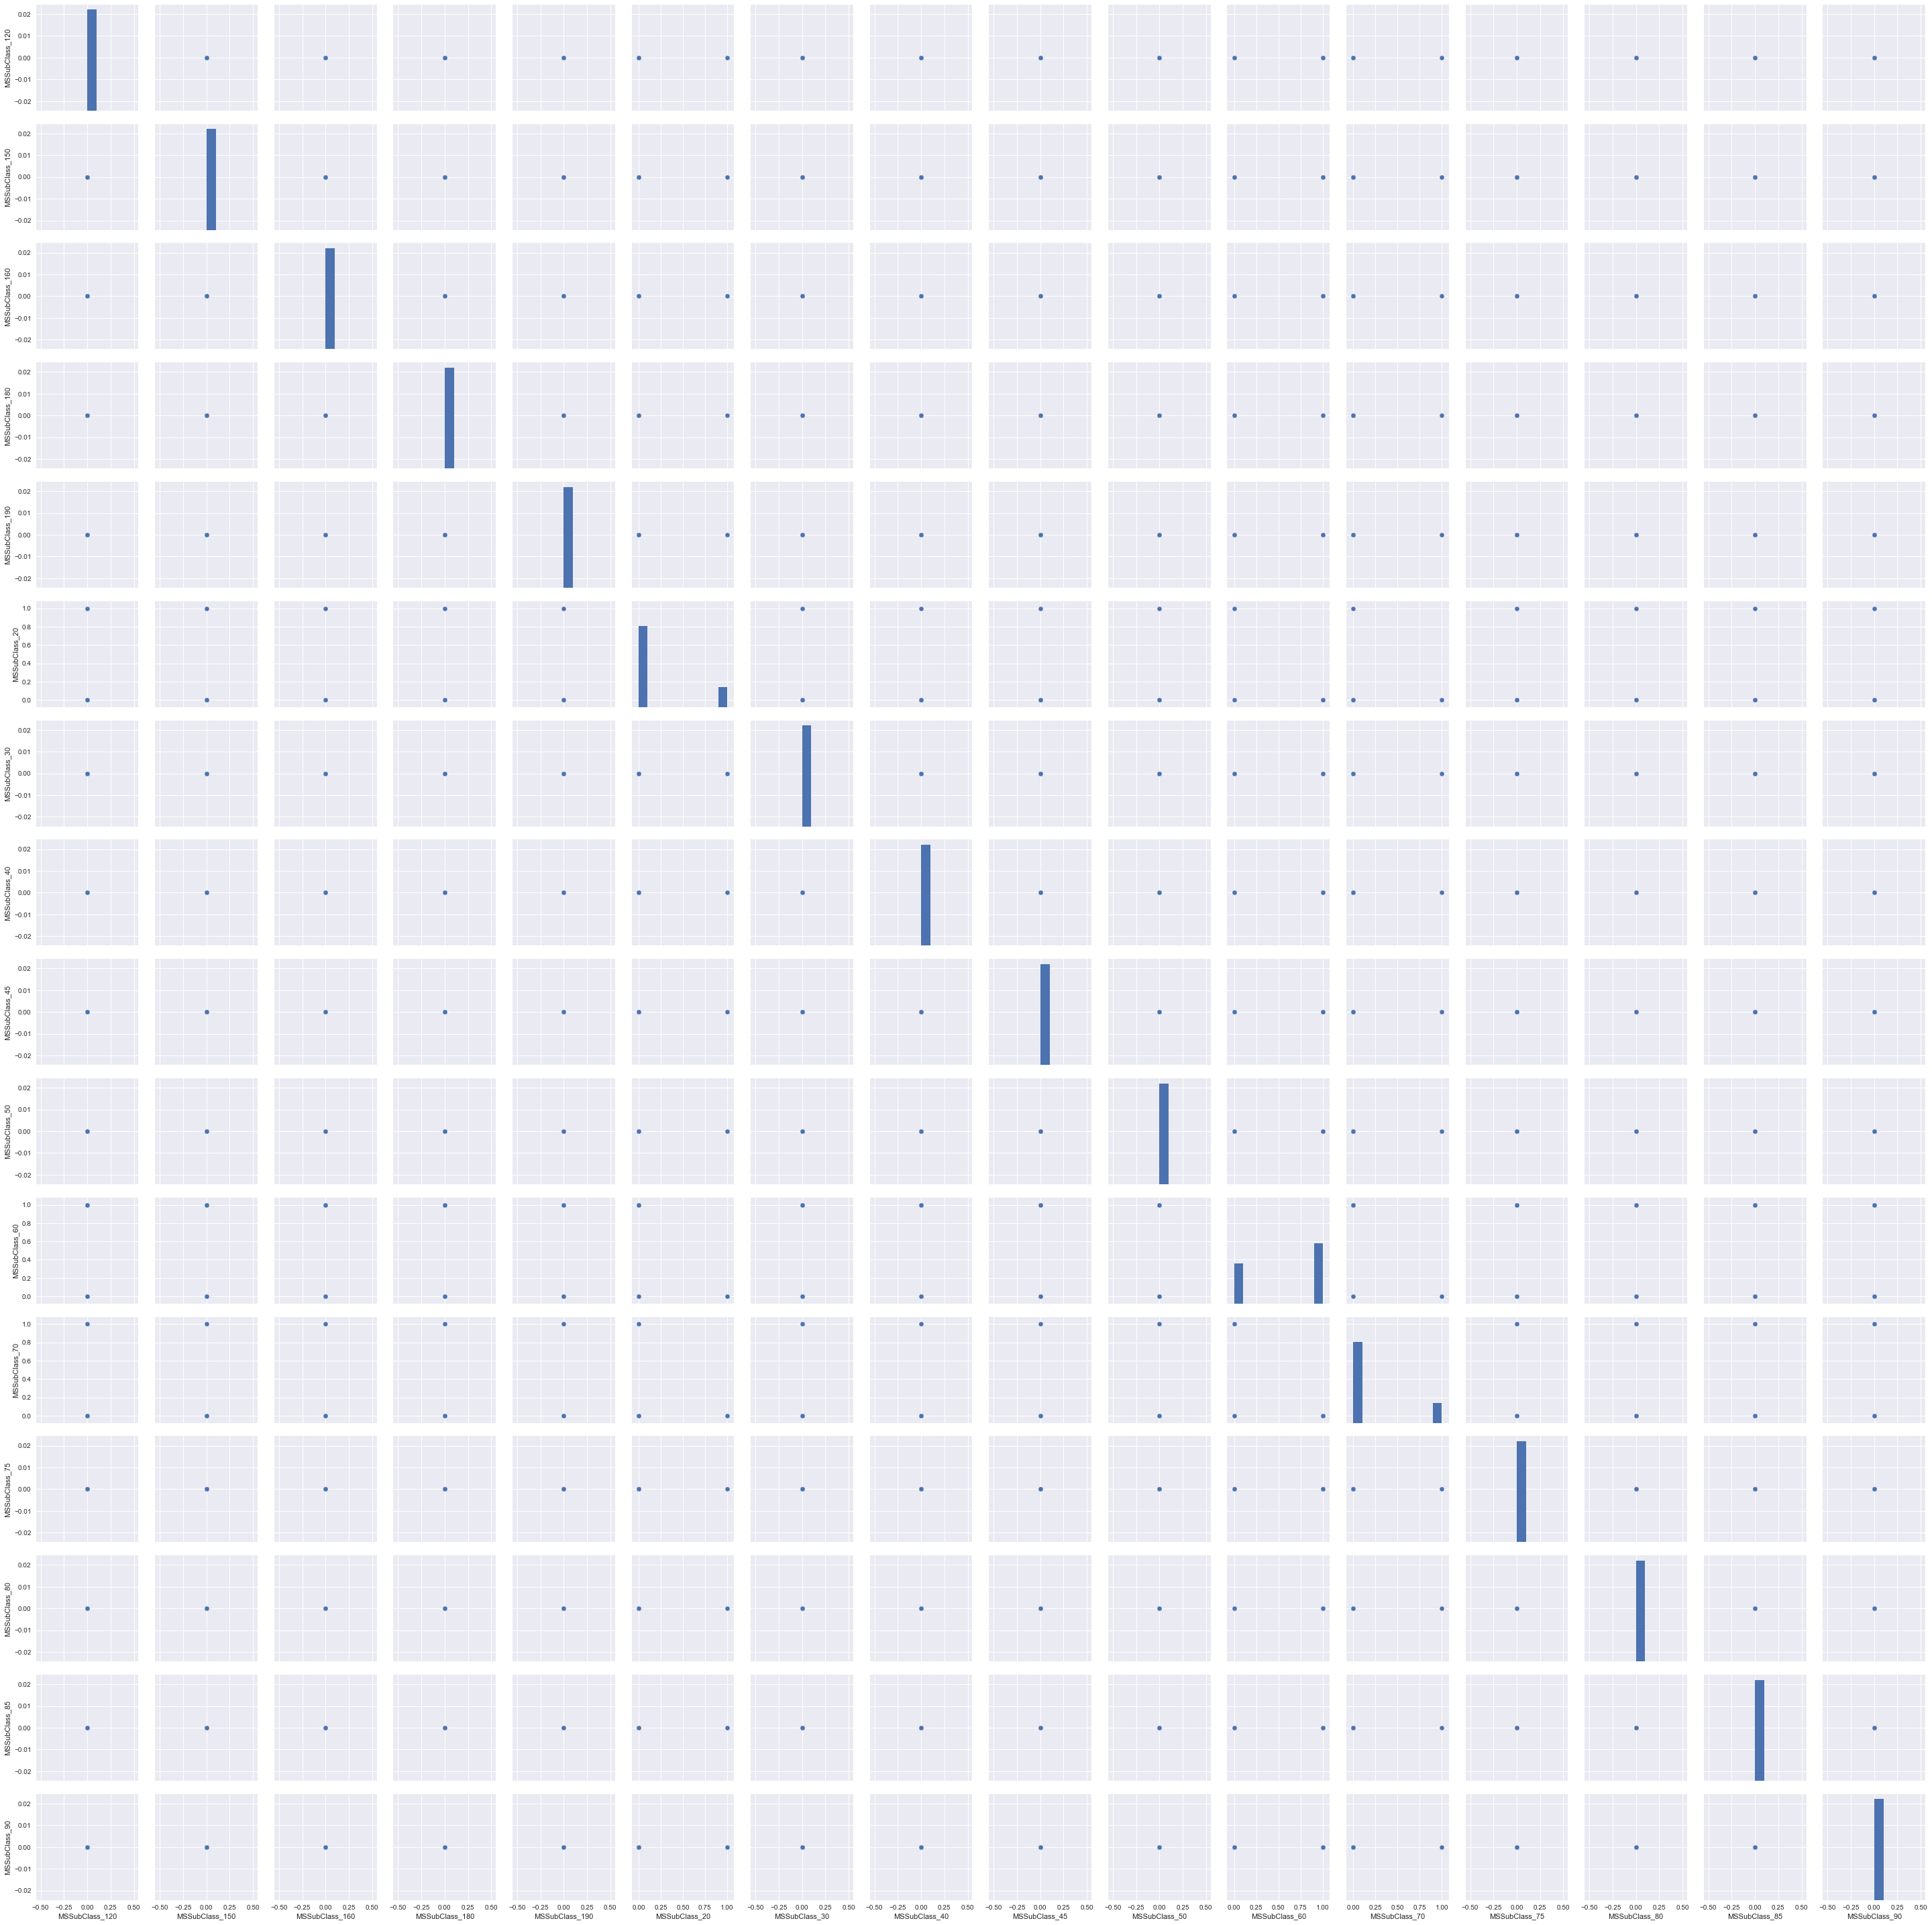

In [8]:
# step3 变量转化
#print (all_df['MSSubClass'].dtypes)
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
#print (all_df['MSSubClass'].dtypes)
#print (all_df['MSSubClass'].value_counts())
# 把category的变量转变成numerical表达形式
# get_dummies方法进行one-hot编码
#print (pd.get_dummies(all_df['MSSubClass'],prefix = 'MSSubClass').head())
sns.pairplot(pd.get_dummies(all_df['MSSubClass'],prefix = 'MSSubClass').head())

In [9]:
all_dummy_df = pd.get_dummies(all_df)
print (all_dummy_df.head())
#sns.pairplot(all_dummy_df.head())

    LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                            
1          65.0     8450            7            5       2003          2003   
2          80.0     9600            6            8       1976          1976   
3          68.0    11250            7            5       2001          2002   
4          60.0     9550            7            5       1915          1970   
5          84.0    14260            8            5       2000          2000   

    MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF          ...            \
Id                                                         ...             
1        196.0       706.0         0.0      150.0          ...             
2          0.0       978.0         0.0      284.0          ...             
3        162.0       486.0         0.0      434.0          ...             
4          0.0       216.0         0.0      540.0          ...    

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
BsmtFinSF1        1
dtype: int64
0


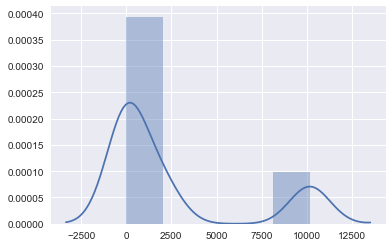

In [10]:
# 处理变量中的缺失值
print (all_dummy_df.isnull().sum().sort_values(ascending = False).head(11))
# 用mean填充
mean_cols = all_dummy_df.mean()
#print (mean_cols.head(10))
sns.distplot(mean_cols.head())
all_dummy_df = all_dummy_df.fillna(mean_cols)
print (all_dummy_df.isnull().sum().sum())

In [11]:
# 标准化numerical数据
numeric_cols = all_df.columns[all_df.dtypes != 'object']
print (numeric_cols)
numeric_col_means = all_dummy_df.loc[:,numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:,numeric_cols].std()
all_dummy_df.loc[:,numeric_cols] = (all_dummy_df.loc[:,numeric_cols] - numeric_col_means) / numeric_col_std

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [12]:
# step4 建立模型
# 把数据处理之后，送回训练集和测试集
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
print (dummy_train_df.shape,dummy_test_df.shape)

(1460, 303) (1459, 303)


In [13]:
# 将DF数据转换成Numpy Array的形式，更好地配合sklearn

X_train = dummy_train_df.values
X_test = dummy_test_df.values

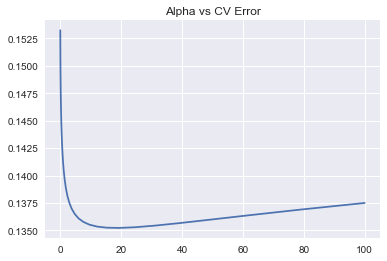

In [14]:
# 随机森林
alphas = np.logspace(-3,2,50)
test_scores = []
for alpha in alphas:
  clf = Ridge(alpha)
  test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv = 10,scoring = 'neg_mean_squared_error'))
  test_scores.append(np.mean(test_score))
plt.plot(alphas,test_scores)
plt.title('Alpha vs CV Error')
plt.show()

In [15]:
# Step 5: 整合

ridge = Ridge(alpha = 15)
rf = RandomForestRegressor(n_estimators = 500,max_features = .3)
ridge.fit(X_train,y_train)
rf.fit(X_train,y_train)

y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))

y_final = (y_ridge + y_rf) / 2

      Id      SalePrice
0   1461  119126.634040
1   1462  151419.291576
2   1463  174953.762999
3   1464  189767.707888
4   1465  195770.257546
5   1466  176103.228555
6   1467  177546.629179
7   1468  168897.293223
8   1469  185536.034049
9   1470  123211.837929
10  1471  187218.949653
11  1472   98090.975880
12  1473   97538.264470
13  1474  147954.825267
14  1475  119479.978528
15  1476  356422.167253
16  1477  246015.940387
17  1478  302666.568096
18  1479  287083.343781
19  1480  472596.238404


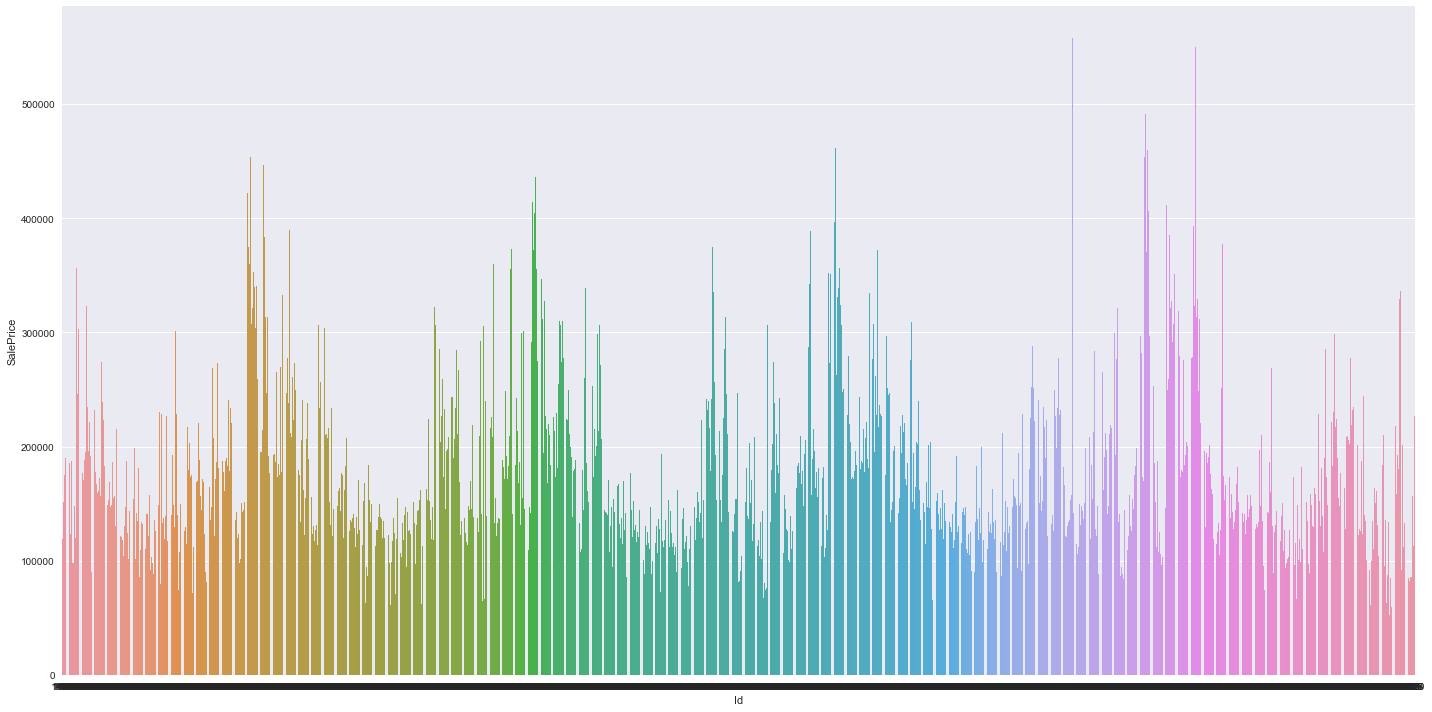

In [24]:
# Step 6: 提交结果
submission_df = pd.DataFrame(data = {'Id':test_df.index,'SalePrice':y_final})
print (submission_df.head(20))
#sns.distplot(submission_df['Id'], kde=False) # 不显示密度曲线
#sns.axlabel('HouseID', 'Price') # 设置X轴和Y轴的坐标含义
sns.factorplot(data=submission_df, x='Id', y="SalePrice", kind="bar", size=10, aspect=2)
sns.plt.show()
submission_df.to_csv('.\\data\\submission.csv',columns = ['Id','SalePrice'],index = False)